# Initial Gdrive setup

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

DATA_PATH = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    DATA_PATH = root_path + "/Proj2_Heritage_places_in_CGR_classify"
    for filename in os.listdir(DATA_PATH):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


## Importing pytorch and setup CPU or GPU

In [ ]:
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


#### Setup random state

In [ ]:
# define the random seed
SEED = 1

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

# Data Importing and Modification and Loading

In [ ]:
# path_train_data= DATA_PATH + "/train_df.csv"
# path_test_data= DATA_PATH + "/test_df.csv"
csv_data_path = DATA_PATH + "/data.csv"

## Train-Test Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSV data into a DataFrame
df = pd.read_csv(csv_data_path)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['class'])

In [ ]:
print('------------ Training set class frequencies ----------------')
print(train_df['class'].value_counts().sort_index())

------------ Training set class frequencies ----------------
class
charch         11
clock_tower     6
jora_ghat      14
mondir          7
musium         13
patalbari       7
Name: count, dtype: int64


In [ ]:
print('------------ Test set class frequencies ----------------')
print(test_df['class'].value_counts().sort_index())

------------ Test set class frequencies ----------------
class
charch         3
clock_tower    2
jora_ghat      3
mondir         2
musium         3
patalbari      2
Name: count, dtype: int64


## Define data transformations

In [ ]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=256

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    # transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((px, px)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])


print(train_transform)

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomAffine(degrees=[0.0, 0.0])
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

### Custom class for loading csv data

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # self.dataframe = pd.DataFrame(pd.read_csv(csv_file))
        self.dataframe = dataframe
        self.transform = transform
        # Create a mapping from class name to index
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.dataframe['class'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = DATA_PATH + self.dataframe.iloc[idx]['path']
        label_name = self.dataframe.iloc[idx]['class']

        # read_image returns a tensor with shape [C, H, W]
        image = Image.open(img_path).convert('RGB') #RGB channel must
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        # Convert label name to index
        label = self.class_to_idx[label_name]

        return image, label


### Load csv with torch with transformation applied

In [ ]:
# load
train_dataset = CustomImageDataset(dataframe=train_df, transform=train_transform)
test_dataset = CustomImageDataset(dataframe=test_df, transform=test_transform)

print(train_dataset)
print(test_dataset)
print("\n classes................\n",train_dataset.class_to_idx)


 classes................
 {'jora_ghat': 0, 'musium': 1, 'clock_tower': 2, 'mondir': 3, 'charch': 4, 'patalbari': 5}


## Data loader

### Define ***Batch-Size (Hyper-parameter)***

In [ ]:
BATCH_SIZE = 16

### Create DataLoader instances

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(train_loader)
print(test_loader)

# Example of iterating through the DataLoader
print(train_dataset.class_to_idx)
# print(len(train_dataset.class_to_idx))
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break # Just show one batch


{'jora_ghat': 0, 'musium': 1, 'clock_tower': 2, 'mondir': 3, 'charch': 4, 'patalbari': 5}
Batch of images shape: torch.Size([16, 3, 224, 224])
Batch of labels shape: torch.Size([16])


### Visualization of transformation

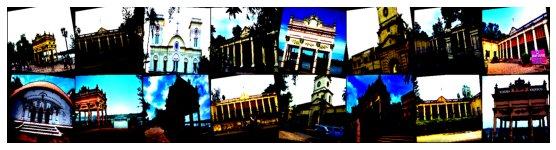

labels: tensor([0, 1, 4, 1, 0, 2, 1, 1, 3, 0, 0, 1, 2, 0, 1, 0])


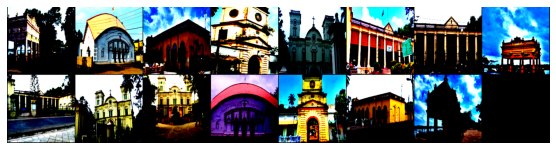

labels: tensor([0, 1, 2, 3, 4, 5, 5, 0, 5, 4, 4, 1, 3, 2, 0])


In [ ]:
def disp_img_grid(dataloader, mean, std):
    batch = next(iter(dataloader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=8)
    plt.figure(figsize=(10, 10), dpi=70)

    # Ensure the pixel values are within the displayable range [0, 1] or [0, 255]
    # Clamping to [0, 1] is usually sufficient for imshow
    grid = torch.clamp(grid, 0, 1)

    plt.imshow(grid.permute(1, 2, 0).numpy()) # c0/h1/w2 -> h0/w1/c2
    plt.axis('off')
    plt.show()
    print(f'labels: {lbl}')

# Example usage with your existing DataLoaders:
disp_img_grid(train_loader, mean=mean, std=standev)
disp_img_grid(test_loader, mean=mean, std=standev)

# CNN Defining and Training part

## Use Readymade CNN Model and modify it

In [ ]:
import torchvision.models as models
import torch.nn as nn

# CNN_MODEL = models.resnet18(weights = None) # pretrained = False)
CNN_MODEL = models.efficientnet_b1(weights = None) # pretrained = False)

If you use a pretrained model (`pretrained = True`),  
you might freeze some layers (`requires_grad = False`) to keep their learned features and only train the new layers.

In [ ]:
# CNN_MODEL = models.resnet18(weights ='ResNet18_Weights.DEFAULT')
# CNN_MODEL = models.efficientnet_b1(weights ='EfficientNet_B1_Weights.DEFAULT')

# Freeze all parameters in the feature extraction layers better forn low dataset
# for param in CNN_MODEL.parameters(): param.requires_grad = False

### Model's Weights and biases Initialization

In [ ]:
import torch.nn.init as init

for module in CNN_MODEL.modules():
    if isinstance(module, nn.Linear):
        init.kaiming_normal_(
            module.weight, a=0, mode='fan_out', nonlinearity='relu',
        )
        if module.bias is not None:
            fan_in, fan_out = init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / (fan_out)**0.5
            init.normal_(module.bias, -bound, bound)

### We have to modify the last layer

In [ ]:
import torch.nn as nn
# modifying the last layer

# ResNet models have a 'fc' layer as the last linear layer
# EffNet models have classifier[] as the last layer
last_layer_in = CNN_MODEL.classifier[1].in_features
no_of_classes = len(train_dataset.class_to_idx)

new_mid_layer_out = 512

print(f"last layer output for model = {last_layer_in} -> {new_mid_layer_out} -> convert to {no_of_classes} output")

# CNN_MODEL.fc = nn.Linear(last_layer_in, no_of_classes)
CNN_MODEL.fc = nn.Sequential(
    torch.nn.Linear(in_features=last_layer_in, out_features=new_mid_layer_out),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(
        in_features=new_mid_layer_out,
        out_features=len(train_dataset.class_to_idx),
    ),
    torch.nn.Softmax(dim=1),
)



last layer output for model = 1280 -> 512 -> convert to 6 output


### Send the model to GPU/CPU

In [ ]:
# Move model to device
CNN_MODEL = CNN_MODEL.to(DEVICE)
print(CNN_MODEL)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Define loss function

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()
print(loss_fn)

CrossEntropyLoss()


### Define ***Hyper-parameter(learning rate)***

In [ ]:
# set hyperparameter
# LEARNING_RATE = 0.001
LEARNING_RATE = 0.0005

### Define optimaizer

In [ ]:
import torch.optim as optim
# define optimizer (Adam, SGD, Adagard)

# Adam Optimizer..
optimizer = optim.Adam(CNN_MODEL.parameters(), lr=LEARNING_RATE)

# SGD with momentum
# optimizer = optim.SGD(CNN_MODEL.parameters(), lr=LEARNING_RATE, momentum=0.9)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


## Defining functions for train and validation

### function for training

In [ ]:
def train_NN(model, train_loader, test_loader, loss_function, optim, n_epochs=10, train_only=False):
    loss_graph_list, accy_list, valid_loss_list = [], [], [] # Changed variable name to avoid conflict
    for epoch in (range(n_epochs)):
        model.train()  # Set the model to training mode
        training_loss = [] # list to store the training loss for each batch

        for i_image, i_label in train_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            optimizer.zero_grad() # Zero out the gradients to prevent accumulation
            output = model(i_image) # Get the model's output for the current batch of imgs
            loss = loss_function(output, i_label) # Calculate the loss using the defined loss function
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update the model's weights using the optimizer

            training_loss.append(loss.item())

        print(f"Training loss at iteration--{epoch+1} is:- {np.mean(training_loss)}")
        loss_graph_list.append(np.mean(training_loss))
        if not train_only:
            accy, current_valid_loss = eval_model_on_test(model, test_loader, loss_function) # Capture validation loss
            valid_loss_list.append(current_valid_loss) # Append the captured validation loss
            accy_list.append(accy)
    print("Training done.....................")
    return loss_graph_list, accy_list, valid_loss_list # Return the list of validation losses



### Function for validation test

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def eval_model_on_test(model, test_loader, loss_function=loss_fn, display_labels=test_dataset.class_to_idx, disp_confusion_matrix=False):
    model.eval()  # Set the model to evaluation mode
    pred_correctly = 0
    total = 0
    actual_labels = []
    predicted_labels = []
    validation_loss = [] # list to store the validation loss for each batch

    with torch.no_grad():
        for i_image, i_label in test_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            total += i_label.size(0) # number of samples in the current batch
            output = model(i_image)

            # Calculate validation loss
            loss = loss_function(output, i_label)
            validation_loss.append(loss.item())

            # get predicted class index (max probability) for each image in the batch
            _, predicted = torch.max(output.data, dim=1) # its indx along (dimension 1,which corresponds to the class scores).
            pred_correctly += (predicted == i_label).sum().item() # count total

            # Collect actual_labels & pridected_labels for confusion matrix
            actual_labels.extend(i_label.cpu().numpy()) # tensor -> NP array and extending the list.
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100.0 * pred_correctly / total
    average_validation_loss = np.mean(validation_loss) # Calculate the average validation loss
    print(f' --Validation loss:- {average_validation_loss}', end='') # Print the validation loss
    print(f' --Testing....got-({pred_correctly}/{total})-correctly-->>accuracy=({accuracy:.2f}%)')


    # Generate and display confusion matrix
    if disp_confusion_matrix:
        ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix(actual_labels, predicted_labels),
            display_labels=display_labels
        ).plot()
        plt.xticks(rotation=90)
        plt.show()
    return accuracy, average_validation_loss # Return both accuracy and validation loss


## Doing train

tune hyperparameter for experiment

- random state [change SEED](#scrollTo=Setup_random_state)
- batch size [change BATCH SIZE](#scrollTo=Define_Batch_Size_Hyper_parameter_)
- learning rate [change LEARNING RATE](#scrollTo=Define_Hyper_parameter_learning_rate_)
- no of epoches or iteration


In [ ]:
# Set no of epoches or train iteration
ITERATION = 20
# call train funtion
iter_loss, iter_accy, valid_loss = train_NN(
    CNN_MODEL, train_loader, test_loader, loss_fn, optimizer, n_epochs=ITERATION,
)

Training loss at iteration--1 is:- 6.8897013664245605
 --Validation loss:- 6.794204235076904 --Testing....got-(3/15)-correctly-->>accuracy=(20.00%)
Training loss at iteration--2 is:- 6.489667654037476
 --Validation loss:- 6.523827075958252 --Testing....got-(3/15)-correctly-->>accuracy=(20.00%)
Training loss at iteration--3 is:- 5.681408882141113
 --Validation loss:- 6.250521659851074 --Testing....got-(2/15)-correctly-->>accuracy=(13.33%)
Training loss at iteration--4 is:- 5.153920292854309
 --Validation loss:- 5.898653507232666 --Testing....got-(2/15)-correctly-->>accuracy=(13.33%)
Training loss at iteration--5 is:- 4.2121588587760925
 --Validation loss:- 5.378791809082031 --Testing....got-(2/15)-correctly-->>accuracy=(13.33%)
Training loss at iteration--6 is:- 3.8265435099601746
 --Validation loss:- 4.884159564971924 --Testing....got-(2/15)-correctly-->>accuracy=(13.33%)
Training loss at iteration--7 is:- 2.9676961302757263
 --Validation loss:- 4.4732537269592285 --Testing....got-(2/1

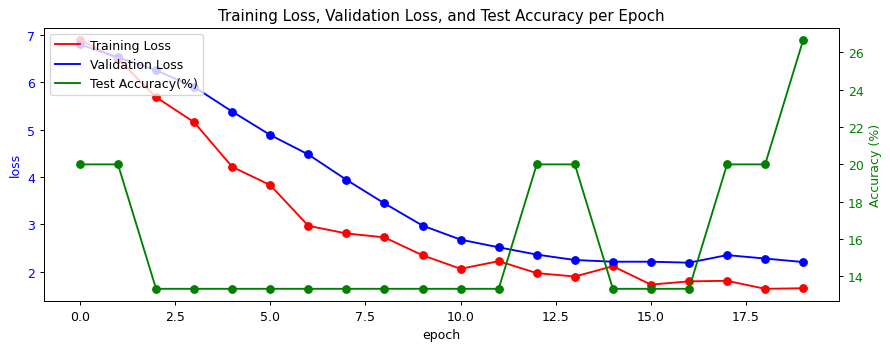

In [ ]:
import matplotlib.pyplot as plt

def ploting(ax, arr, color,lname, ylabel='loss', xlabel='epoch'):
    ax.plot(arr, color=color, label=lname)
    ax.scatter(range(len(arr)), arr, color=color)
    ax.set_ylabel(ylabel, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xlabel(xlabel)


# Create a figure and the first axes
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=90)
# Create a second axes that shares the same x-axis as the first
ax2 = ax1.twinx()

# Plotting loss and valid loss on ax1 (left y-axis)
ploting(ax1, iter_loss, color='red', lname='Training Loss')
ploting(ax1, valid_loss, color='blue', lname='Validation Loss')
# Plotting accuracy on ax2 (right y-axis)
ploting(ax2, iter_accy, color='green', lname='Test Accuracy(%)',ylabel='Accuracy (%)')

# Add a legend: Combine handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# Create a single legend for all lines
plt.legend(handles1 + handles2, labels1 + labels2, loc='lower left')

plt.title('Training Loss, Validation Loss, and Test Accuracy per Epoch')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Validate the model

In [ ]:
# call evaluation function
accuracy,_ = eval_model_on_test(
    CNN_MODEL, test_loader, disp_confusion_matrix=True,
)

## Save trained model

In [ ]:
# print(CNN_MODEL.state_dict())
# torch.save(CNN_MODEL.state_dict(), DATA_PATH +'/resnet18_image_classifier.pth')

#save entire model
model_name = CNN_MODEL.__class__.__name__ + 'b1' # change accordingly (b0,b2,b3,b4, v2_s,v2_m)

# generate save file name with hyperparameters
filename = f"{model_name}_accy-{int(accuracy)}_(lr-{LEARNING_RATE}_bs-{BATCH_SIZE}_ep-{ITERATION}_sd-{SEED}).pth"

# save only if get a higher accuracy
if accuracy > 50:
    torch.save(CNN_MODEL, DATA_PATH + '/' + filename)
    print(model_name,' saved as', filename)

os.listdir(DATA_PATH)

# Individual testing

## Predefined parameters

In [ ]:
# MODEL = DATA_PATH+"/resnet18_image_classifier_full.pth"
MODEL = CNN_MODEL
TRANSFORM = test_transform
# Update the CATEGORIES variable to be a list of keys
CATEGORIES = list(test_dataset.class_to_idx.keys())
print(CATEGORIES)


## Function for individual image classification

In [ ]:
from PIL import Image

def classify_this_image(img_path, model=MODEL,img_transform=TRANSFORM,classes=CATEGORIES):
    model.eval() # set model to evaluation/testing mode
    input_img = Image.open(DATA_PATH + img_path)

    plt.figure(figsize=(10, 10),dpi=30)
    plt.imshow(input_img) # display the loaded image
    plt.axis('off')
    plt.show()

    img_tensor = img_transform(input_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        print(probabilities)
        _, predicted_class_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_class_index.item()]
        print(f"Predicted class: {predicted_class}")

## Input image and Classify

In [ ]:
# GradCAM